In [43]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [44]:
def read_crypto_data(ticker):
    df = pd.read_csv(f'../data/validation/{ticker}_1_MIN_INTERVAL.csv', parse_dates=['Time'])
    df.columns = ['ds', 'y']

    return df

In [45]:
def calculate_conf_intervals_first_second_derivatives_denoising(df):
    def calculate_derivatives(coefficients):
        inverted_coefficients = np.flip(coefficients)
        new_coefficients_fliped = np.zeros(coefficients.shape[0] - 1)
        for i in range(coefficients.shape[0] - 1):
            new_coefficients_fliped[i] = inverted_coefficients[i + 1] * (i + 1)

        new_coefficients = np.flip(new_coefficients_fliped)
        y_deriv_model = np.poly1d(new_coefficients)
        y_deriv_analitic = y_deriv_model(x)

        return y_deriv_analitic, new_coefficients

    y = df['y'].to_numpy()
    x = range(len(y)) 
    coefficients = np.polyfit(x, y, 15)
    y_model = np.poly1d(coefficients)
    y_denoised = y_model(x)
    stat = y - y_denoised
    stat = stat - stat.mean()
    y_first_derivative_analitic,  coefficients_first_derivative = calculate_derivatives(coefficients)
    y_second_derivative_analitic, coefficients_second_derivative = calculate_derivatives(coefficients_first_derivative)

    residuals = y - y_denoised
    lower, upper = np.percentile(residuals, [5, 95])
    lower_confidence_interval = y_denoised + lower
    upper_confidence_interval = y_denoised + upper
    
    return lower_confidence_interval, upper_confidence_interval, y_first_derivative_analitic, y_second_derivative_analitic, y_denoised

def calculate_overestimate(row):
        if row.y > row.UPPER_CONFIDENCE_INTERVAL_90:
            return 1
        else:
            return 0

def calculate_underestimate(row):
    if row.y < row.LOWER_CONFIDENCE_INTERVAL_90:
        return 1
    else:
        return 0
    
def create_buy_sell_none_signals(row):
        if row.PCT_CHANGE >= 0.5:
            return 'BUY'
        elif row.PCT_CHANGE <= -0.5:
            return 'SELL'
        else:
            return 'NONE'

In [46]:
def create_all_features(df):
    df['FUTURE_1_Y'] = df.y.shift(-1)
    df['FUTURE_2_Y'] = df.y.shift(-2)
    df['FUTURE_3_Y'] = df.y.shift(-3)
    df.dropna(how='any', axis=0, inplace=True)
    df['PCT_CHANGE'] = ((df['FUTURE_3_Y'] / df['y']) - 1) * 100
    df.drop(['FUTURE_1_Y', 'FUTURE_2_Y', 'FUTURE_3_Y'], axis=1, inplace=True)
    
    lower_confidence_interval, upper_confidence_interval, y_first_derivative_analitic, y_second_derivative_anality, y_denoised = calculate_conf_intervals_first_second_derivatives_denoising(df)

    df['CHANGE_VELOCITY'] = y_first_derivative_analitic
    df['ACCELERATION'] = y_second_derivative_anality
    df['POLYNOMIAL_REG'] = y_denoised
    df['LOWER_CONFIDENCE_INTERVAL_90'] = lower_confidence_interval
    df['UPPER_CONFIDENCE_INTERVAL_90'] = upper_confidence_interval
    df['SIGNAL'] = df.apply(create_buy_sell_none_signals, axis=1)
    df['OVERESTIMATE'] = df.apply(calculate_overestimate, axis=1)
    df['UNDERESTIMATE'] = df.apply(calculate_underestimate, axis=1)
        
    return df

In [47]:
def create_time_series_folds(df, n_splits, train_size=(365*24), test_size=(30*24), gap=(30*24*2)):
    tss = TimeSeriesSplit(gap=gap, max_train_size=train_size, n_splits=n_splits, test_size=test_size)

    folds = list()
    for train, test in tss.split(df):
        folds.append((train, test))
    
    return folds

In [48]:
def create_folds_and_interval_df(df, interval):
    train_size = None
    test_size = None
    if interval == '5M':
        df_interval = df[df['ds'].dt.minute % 5 == 0].copy()
        train_size = (365*36*12) # year and a half
        test_size = (30*24*12*3) # 3 months
    if interval == '15M':
        df_interval = df[df['ds'].dt.minute % 15 == 0].copy()
        train_size = (365*36*4) # year and a half
        test_size = (30*24*4*3) # 3 months
    elif interval == '30M':
        df_interval = df[df['ds'].dt.minute % 30 == 0].copy()
        train_size = (365*36*2) # year and a half
        test_size = (30*24*2*3) # 3 months
    elif interval == '1H':
        df_interval = df[df['ds'].dt.minute == 0].copy()
        train_size = (365*36*1) # year and a half
        test_size = (30*24*3) # 3 months
    elif interval == '2H':
        df_interval = df[(df['ds'].dt.hour % 2 == 0) & (df['ds'].dt.minute == 0)].copy()
        train_size = (365*18*1) # year and a half
        test_size = (30*12*3) # 3 months
    elif interval == '4H':
        df_interval = df[(df['ds'].dt.hour % 4 == 0) & (df['ds'].dt.minute == 0)].copy()
        train_size = (364*9) # year and a half
        test_size = (30*6*3) # 3 months
    elif interval == '6H':
        df_interval = df[(df['ds'].dt.hour % 6 == 0) & (df['ds'].dt.minute == 0)].copy()
        train_size = (365*6) # year and a half
        test_size = (30*4*3) # 3 months
    elif interval == '12H':
        df_interval = df[(df['ds'].dt.hour % 12 == 0) & (df['ds'].dt.minute == 0)].copy()
        train_size = (365*3) # year and a half
        test_size = (30*2*3) # 3 months
    elif interval == '24H':
        df_interval = df[(df['ds'].dt.hour == 0) & (df['ds'].dt.minute == 0)].copy()
        train_size = (546)
        test_size = (90) # 3 months

    n_splits = (df_interval.shape[0] - train_size) // test_size
    folds = create_time_series_folds(df=df_interval, n_splits=n_splits, train_size=train_size, test_size=test_size, gap=0)
    print(len(folds))
    
    return df_interval, folds

In [49]:
def run(ticker, period):
    df = read_crypto_data(ticker)
    df_interval, folds = create_folds_and_interval_df(df, '4H')
    df_interval = create_all_features(df_interval)
    df_interval, folds = create_folds_and_interval_df(df_interval, '4H')
    
    return df_interval, folds

In [50]:
df_interval, folds = run(ticker='BTCEUR', period='24H')

3
3


In [51]:
def calculate_accumulated_investment(y_test, y_test_prices, predictions, fee=0.001, period_labels=3):
    open_position = False
    accumulated_investment = 1
    buy_price = None
    list_accumulated_investment = list()
    count = 0
    
    for i in range(len(predictions)):
        if open_position:
            accumulated_investment *= (buy_price / predictions[i])
            count += 1
            
        if (open_position == False) & (predictions[i] == 'BUY'):
            accumulated_investment *= (1 - fee)
            buy_price = y_test_prices.iloc[i]
            count = 0
            
        elif (open_position == True) & (predictions[i] == 'SELL') & (count == period_labels):
            accumulated_investment *= (1 - fee)
            buy_price = None
            count = 0
            
        list_accumulated_investment.append(accumulated_investment)
    
    return accumulated_investment, list_accumulated_investment

<AxesSubplot:>

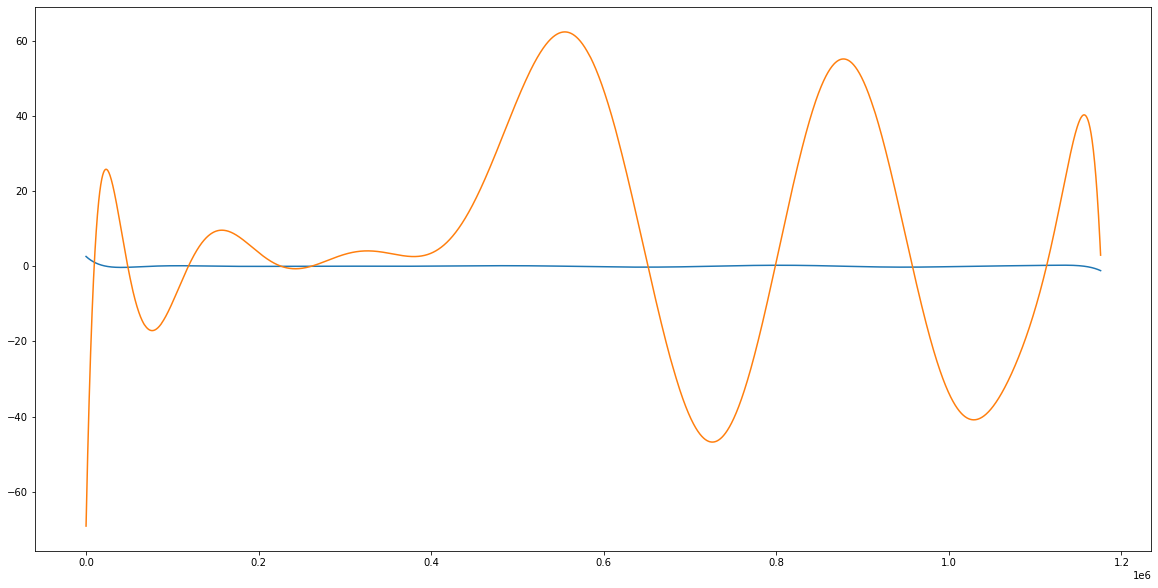

In [52]:
df_interval.ACCELERATION.plot(figsize=(20,10))
df_interval.CHANGE_VELOCITY.plot(figsize=(20,10))

FOLD=1


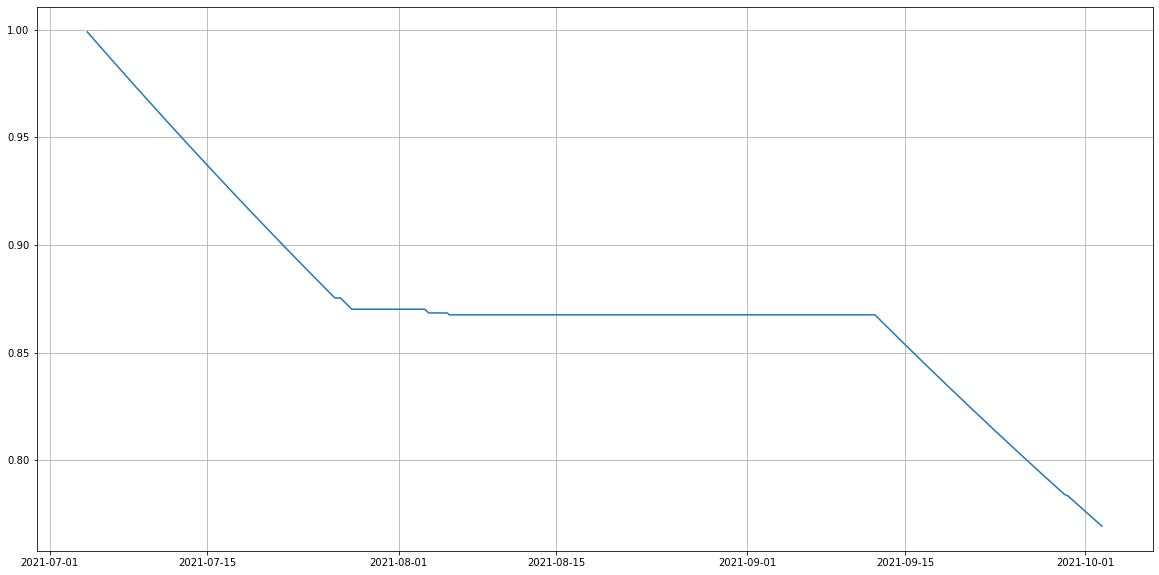

FOLD=2


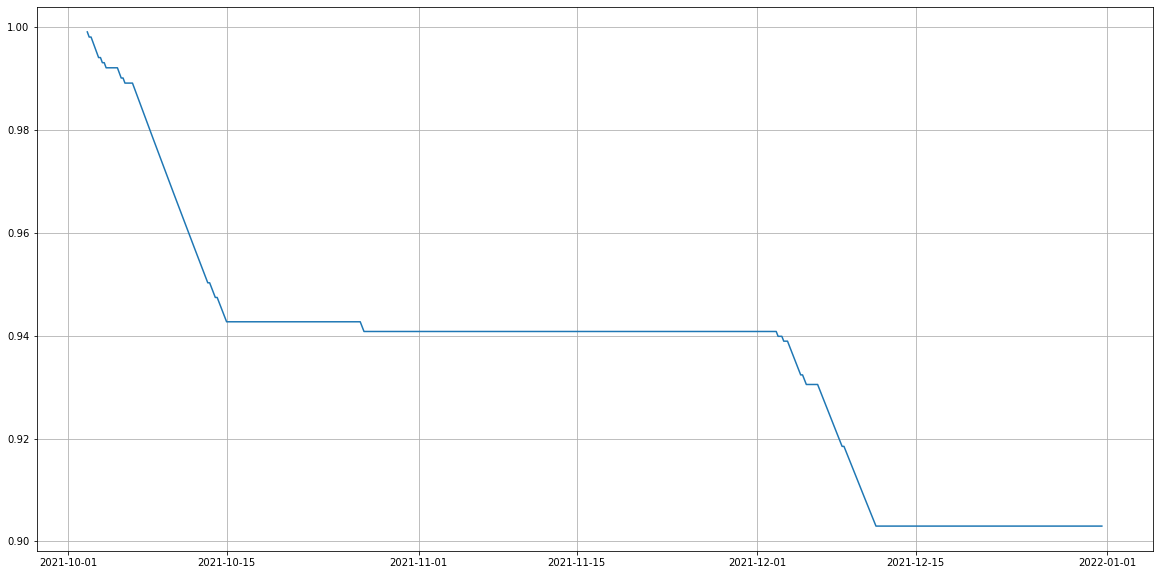

FOLD=3


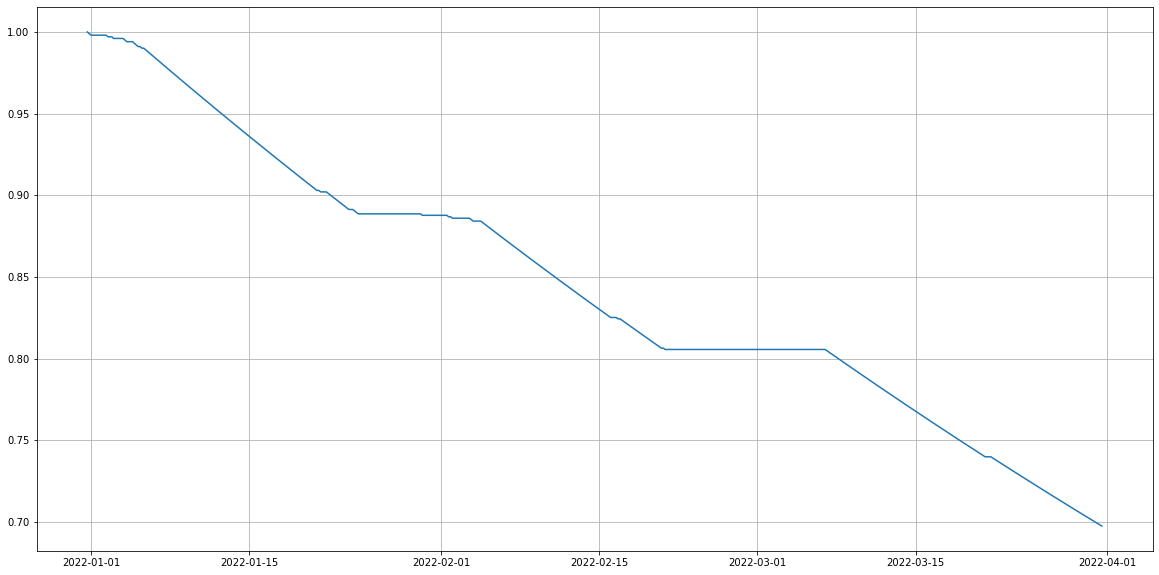

In [53]:
X = df_interval[['CHANGE_VELOCITY', 'ACCELERATION', 'POLYNOMIAL_REG', 'y', 'LOWER_CONFIDENCE_INTERVAL_90', 'UPPER_CONFIDENCE_INTERVAL_90', 'OVERESTIMATE', 'UNDERESTIMATE']]
y = df_interval['SIGNAL']
prices = df_interval['y']
dates = df_interval['ds']

fold_accumulated_investments = list()
fold_accuracy_list = list()
for fold, (train_indexes, test_indexes) in enumerate(folds):
    print(f'FOLD={fold + 1}')
    X_train, X_test = X.iloc[train_indexes,:], X.iloc[test_indexes,:]
    y_train, y_test = y.iloc[train_indexes], y.iloc[test_indexes]
    y_test_prices = prices.iloc[test_indexes]
    y_test_dates = dates.iloc[test_indexes]
    
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    accumulated_investment, list_accumulated_investment = calculate_accumulated_investment(y_test, y_test_prices, predictions)
    fold_accumulated_investments.append(accumulated_investment)
    fold_accuracy_list.append(accuracy_score(y_test, predictions))
    
    fig = plt.figure(figsize=(20,10))
    plt.plot(pd.Series(list_accumulated_investment, index=y_test_dates))
    plt.grid()
    plt.show()

In [54]:
fold_accumulated_investments

[0.7694101571203781, 0.9029834676116293, 0.6975506718651011]

In [55]:
fold_accuracy_list

[0.4166666666666667, 0.38333333333333336, 0.34444444444444444]

In [56]:
predictions, y_test.values

(array(['SELL', 'BUY', 'BUY', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL',
        'SELL', 'SELL', 'SELL', 'BUY', 'SELL', 'SELL', 'BUY', 'SELL',
        'SELL', 'SELL', 'SELL', 'SELL', 'BUY', 'BUY', 'SELL', 'SELL',
        'SELL', 'BUY', 'BUY', 'BUY', 'SELL', 'BUY', 'SELL', 'BUY', 'BUY',
        'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY',
        'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY',
        'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY',
        'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY',
        'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY',
        'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY',
        'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY',
        'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY',
        'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY',
        'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY',
      